In [13]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))
house_prices <- source('main.R', local = TRUE)$value

combined_dataset_step1 <-
    # load data
    house_prices$helpers$load_data() %>%
    # remove outliers
    (house_prices$outliers$remove_outliers) %>%
    # fix NA values
    (house_prices$missing$fix_all) %>%
    # transform Y-variable
    mutate(
        price_log = log(SalePrice)
    ) %>%
    # remove redundant variables
    select(-SalePrice, -Id) %>%
    select(order(colnames(.)))

################################
# transform numeric predictors #
################################

c(combined_dataset_step2, trans_config) %<-%
    house_prices$trans$numeric$functional_transform(
        data = combined_dataset_step1,
        trans = tribble(
            ~tran_name,  ~tran_fn,
            'log',       function(x) log(x+1),
            'sqrt',      function(x) sqrt(x),
            'inv3',      function(x) x**(1/3),
            'inv4',      function(x) x**(1/4)
        ),
        target_var = price_log,        
        threshold = 30
    )    
combined_dataset_step2 <- combined_dataset_step2 %>% select(order(colnames(.)))
                
trans_config

house_prices$helpers$utils$frames_diff(
    combined_dataset_step1, 
    combined_dataset_step2
) %>% head

####################################                
# transform categorical predictors #
####################################
combined_dataset_step3 <- 
    house_prices$trans$categ$rating_transform(
        data = combined_dataset_step2, 
        target_var = price_log
    ) %>% 
    select(order(colnames(.)))

house_prices$helpers$utils$frames_diff(
    combined_dataset_step2, 
    combined_dataset_step3
) %>% head
                
training_dataset <- 
    combined_dataset_step3 %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)

var,tran_name,progress_score,tran_fn
GrLivArea,log,91.15794,"function (x) , log(x + 1)"
X1stFlrSF,log,90.77166,"function (x) , log(x + 1)"
BsmtUnfSF,sqrt,79.97603,"function (x) , sqrt(x)"
LotArea,inv4,78.86403,"function (x) , x^(1/4)"
TotRmsAbvGrd,log,30.68502,"function (x) , log(x + 1)"


BsmtUnfSF.1,BsmtUnfSF.2,GrLivArea.1,GrLivArea.2,LotArea.1,LotArea.2,TotRmsAbvGrd.1,TotRmsAbvGrd.2,X1stFlrSF.1,X1stFlrSF.2
150,12.24745,1710,7.444833,8450,9.587694,8,2.197225,856,6.753438
284,16.85230,1262,7.141245,9600,9.898464,6,1.945910,1262,7.141245
434,20.83267,1786,7.488294,11250,10.298836,6,1.945910,920,6.825460
540,23.23790,1717,7.448916,9550,9.885550,7,2.079442,961,6.869014
490,22.13594,2198,7.695758,14260,10.927728,9,2.302585,1145,7.044033
64,8.00000,1362,7.217443,14115,10.899842,5,1.791759,796,6.680855


Alley.1,Alley.2,BldgType.1,BldgType.2,BsmtCond.1,BsmtCond.2,BsmtExposure.1,BsmtExposure.2,BsmtFinType1.1,BsmtFinType1.2,⋯,RoofStyle.1,RoofStyle.2,SaleCondition.1,SaleCondition.2,SaleType.1,SaleType.2,Street.1,Street.2,Utilities.1,Utilities.2
_none_,2.531822,1Fam,2.564039,TA,2.540871,No,2.320042,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,Gd,3.295455,ALQ,2.231818,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,Mn,2.675439,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,Gd,3.046154,No,2.320042,ALQ,2.231818,⋯,Gable,2.418054,Abnorml,1.920792,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,Av,2.900452,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,No,2.320042,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911


In [47]:
report <- house_prices$model_selection$lm$greedy_r2_gain_adj(
    data = training_dataset, 
    target_var = price_log, 
    r2_gain_discard_level = 0.4,
    r2_discard_level = 0.02, 
    a_max = 0, a_avg = 0
)

formulas_for_validation <-
    report %>% 
    group_by(step) %>% 
    filter(row_number() == 1) %>%
    select(step, formula)

formulas_for_validation

step,formula
1,price_log ~ OverallQual
2,price_log ~ OverallQual + GrLivArea
3,price_log ~ OverallQual + GrLivArea + Neighborhood
4,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1
5,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea
6,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir
7,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea
8,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea + YearRemodAdd
9,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea + YearRemodAdd + TotalBsmtSF
10,price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea + YearRemodAdd + TotalBsmtSF + SaleCondition


In [44]:
L2_avg_loss <- house_prices$helpers$utils$L2_avg_loss

iterate <- function(formulas_for_validation, sample_index, totalset) {
    
    test_y <- totalset[-sample_index, 'price_log'][[1]]

    totalset <- 
        totalset %>% 
        mutate(price_log = replace(price_log, -sample_index, NA))

    totalset <-
        house_prices$trans$categ$rating_transform(
            data = totalset, 
            target_var = price_log
        )

    trainset <- totalset[sample_index,]
    testset <- totalset[-sample_index,]

    formulas_for_validation %>%
    mutate(
        model = map(formula, ~lm(as.formula(.), data=trainset)),

        r2 = map_dbl(model, function (mod) {
            summary(mod)$r.squared
        }),

        L2_train = map_dbl(model, function (mod) {
            augment <- broom::augment(mod)
            L2_avg_loss(augment[['price_log']] - augment$.fitted)
        }),

        L2_test = map_dbl(model, function (mod) {
            test_predicted <- predict(mod, testset)
            L2_avg_loss(test_predicted - test_y)
        })
    ) %>%
    select(-model)
}

In [48]:
dataset <-
    # !!!before transformation of categ variables!!!
    combined_dataset_step2 %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)

dataset %>% nrow

set.seed(8)
suppressWarnings(
    caret::createDataPartition(
        y = dataset[['price_log']], 
        p = 0.5, 
        list = TRUE, 
        times = 10
    ) %>%
    map(function (sample_index) { iterate(formulas_for_validation, sample_index, dataset) })
) %>% 
bind_rows(.id='sample') -> report

[1] 1458

In [49]:
avg_report <-
    report %>%
    group_by(formula) %>%
    summarise(
        r2 = mean(r2),
        L2_train = mean(L2_train),
        L2_test = mean(L2_test),
        step = max(step),
    ) %>%
    mutate(
        L2_test_gain = lag(L2_test) - L2_test
    )

avg_report

formula,r2,L2_train,L2_test,step,L2_test_gain
price_log ~ OverallQual,0.6724516,0.05149759,0.05250277,1,NA
price_log ~ OverallQual + GrLivArea,0.7621208,0.03739894,0.03804852,2,0.0144542507
price_log ~ OverallQual + GrLivArea + Neighborhood,0.8111162,0.02969291,0.03054179,3,0.0075067307
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1,0.8456728,0.02425718,0.02433128,4,0.0062105091
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea,0.8579926,0.02232132,0.02243408,5,0.0018972051
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir,0.8662802,0.02101241,0.02091718,6,0.0015168967
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea,0.8735544,0.01986861,0.01959460,7,0.0013225840
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea + YearRemodAdd,0.8823531,0.01849098,0.01829155,8,0.0013030415
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea + YearRemodAdd + TotalBsmtSF,0.8874584,0.01768611,0.01734196,9,0.0009495906
price_log ~ OverallQual + GrLivArea + Neighborhood + BsmtFinSF1 + GarageArea + CentralAir + LotArea + YearRemodAdd + TotalBsmtSF + SaleCondition,0.8924121,0.01690669,0.01681691,10,0.0005250552


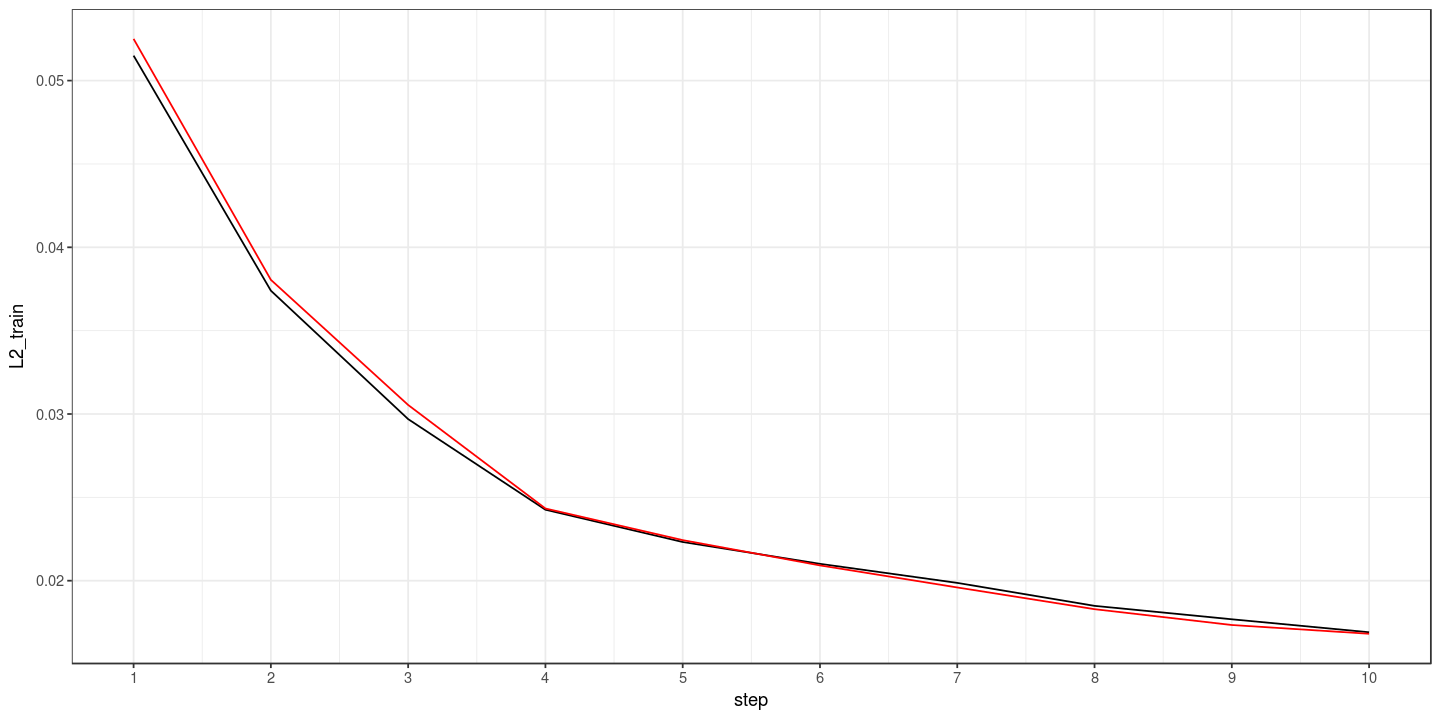

In [41]:
options(repr.plot.width = 12, repr.plot.height = 6)

avg_report %>% 
ggplot() +
geom_line(aes(x=step, y=L2_train, group=1)) +
geom_line(aes(x=step, y=L2_test, group=1), color='red') +
scale_x_continuous(breaks=c(1:max(avg_report$step))) +
theme_bw()

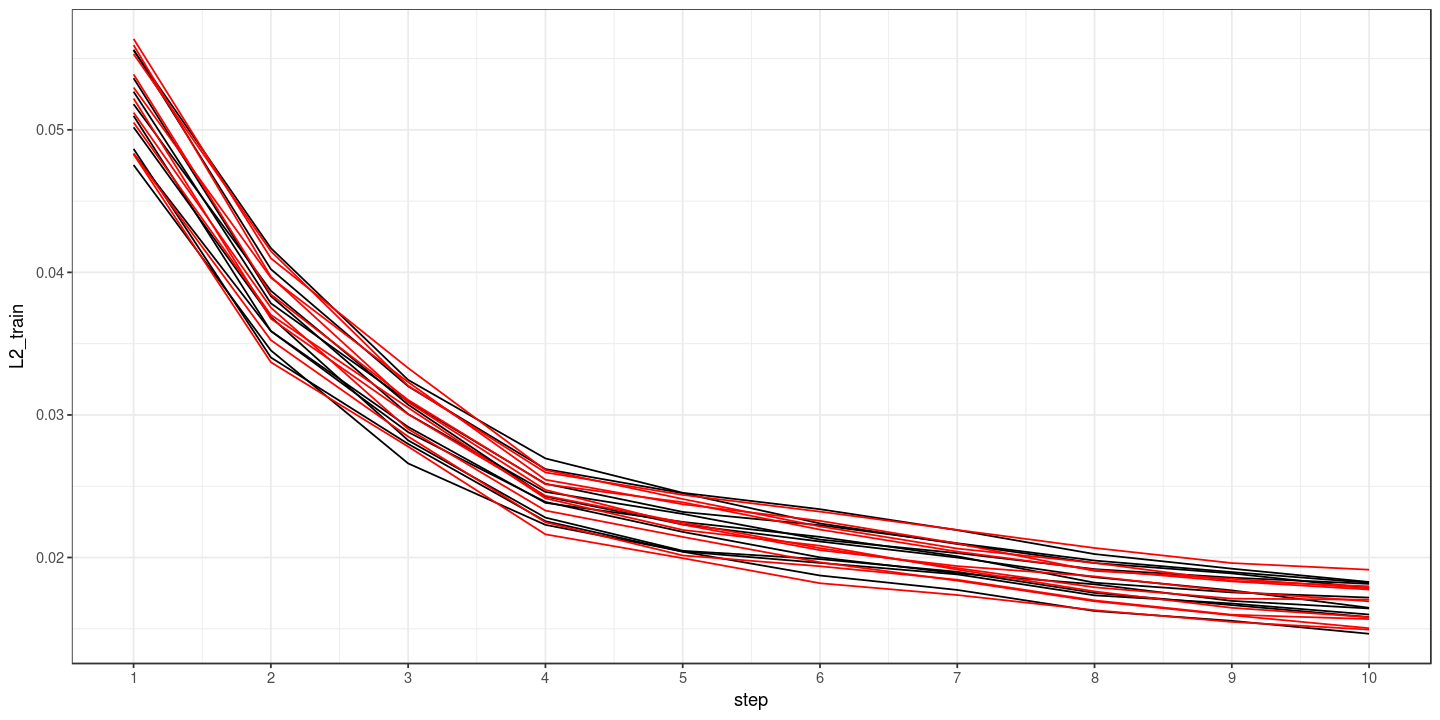

In [42]:
options(repr.plot.width = 12, repr.plot.height = 6)

report %>% 
ggplot() +
geom_line(aes(x=step, y=L2_train, group=sample)) +
geom_line(aes(x=step, y=L2_test, group=sample), color='red') +
scale_x_continuous(breaks=c(1:max(avg_report$step))) +
theme_bw()

In [50]:
report <- house_prices$model_selection$lm$greedy_r2_gain_adj(
    data = training_dataset, 
    target_var = price_log, 
    r2_gain_discard_level = 0.4,
    r2_discard_level = 0.02, 
    a_max = 1, a_avg = 1
)

formulas_for_validation <-
    report %>% 
    group_by(step) %>% 
    filter(row_number() == 1) %>%
    select(step, formula)

formulas_for_validation

step,formula
1,price_log ~ OverallQual
2,price_log ~ OverallQual + LotArea
3,price_log ~ OverallQual + LotArea + GrLivArea
4,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1
5,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt
6,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition
7,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + CentralAir
8,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + CentralAir + KitchenQual
9,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + CentralAir + KitchenQual + Neighborhood
10,price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + CentralAir + KitchenQual + Neighborhood + TotalBsmtSF


In [51]:
dataset <-
    # !!!before transformation of categ variables!!!
    combined_dataset_step2 %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)

dataset %>% nrow

set.seed(8)
suppressWarnings(
    caret::createDataPartition(
        y = dataset[['price_log']], 
        p = 0.5, 
        list = TRUE, 
        times = 10
    ) %>%
    map(function (sample_index) { iterate(formulas_for_validation, sample_index, dataset) })
) %>% 
bind_rows(.id='sample') -> report

[1] 1458

In [52]:
avg_report <-
    report %>%
    group_by(formula) %>%
    summarise(
        r2 = mean(r2),
        L2_train = mean(L2_train),
        L2_test = mean(L2_test),
        step = max(step),
    ) %>%
    mutate(
        L2_test_gain = lag(L2_test) - L2_test
    )

avg_report

formula,r2,L2_train,L2_test,step,L2_test_gain
price_log ~ OverallQual,0.6724516,0.05149759,0.05250277,1,NA
price_log ~ OverallQual + LotArea,0.7425354,0.04048551,0.04067756,2,0.0118252136
price_log ~ OverallQual + LotArea + GrLivArea,0.7924489,0.03263215,0.03304361,3,0.0076339501
price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1,0.8256041,0.02741961,0.02721716,4,0.0058264502
price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt,0.8568478,0.02250598,0.02208950,5,0.0051276565
price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition,0.8657984,0.02109670,0.02099935,6,0.0010901513
price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + CentralAir,0.8712739,0.02022991,0.02001606,7,0.0009832868
price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + CentralAir + KitchenQual,0.8785797,0.01908418,0.01888604,8,0.0011300225
price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + CentralAir + KitchenQual + Neighborhood,0.8848953,0.01808861,0.01803201,9,0.0008540288
price_log ~ OverallQual + LotArea + GrLivArea + BsmtFinSF1 + YearBuilt + SaleCondition + CentralAir + KitchenQual + Neighborhood + TotalBsmtSF,0.8889301,0.01745290,0.01726356,10,0.0007684556


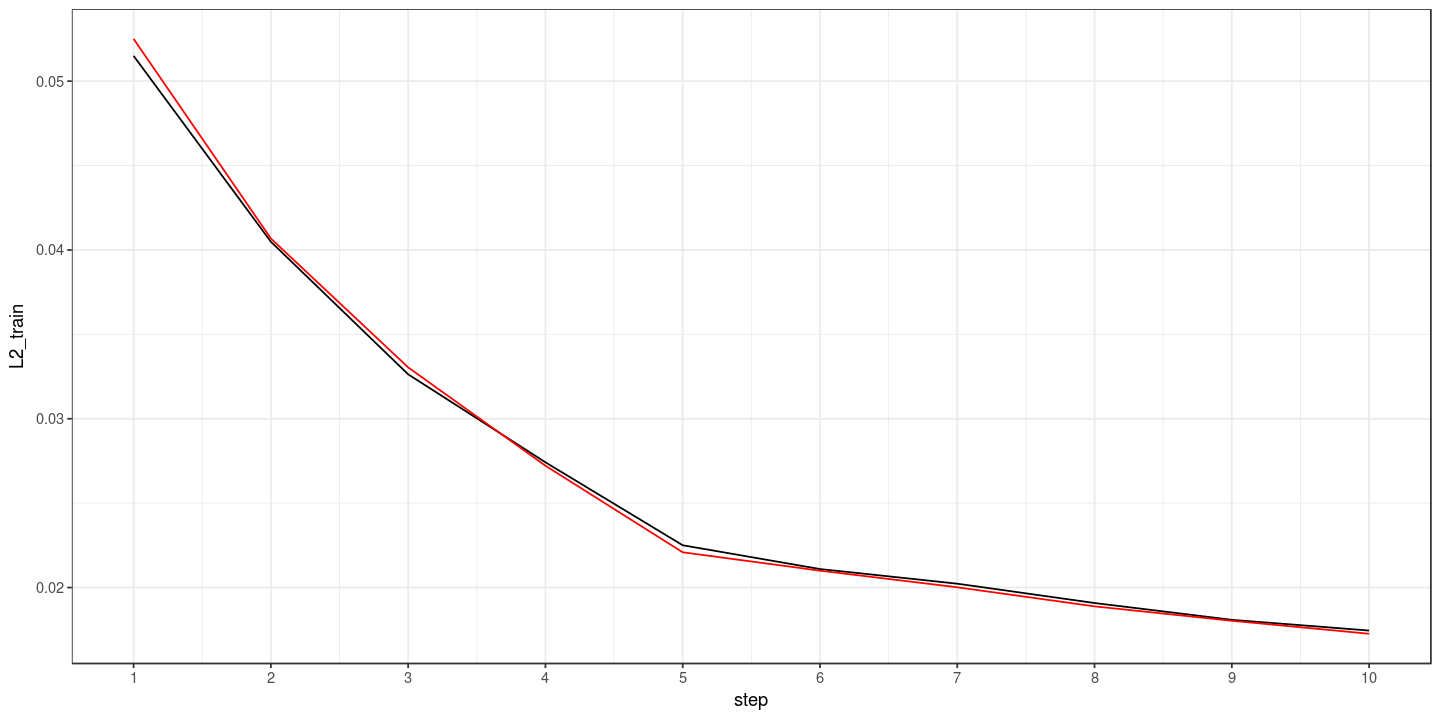

In [53]:
options(repr.plot.width = 12, repr.plot.height = 6)

avg_report %>% 
ggplot() +
geom_line(aes(x=step, y=L2_train, group=1)) +
geom_line(aes(x=step, y=L2_test, group=1), color='red') +
scale_x_continuous(breaks=c(1:max(avg_report$step))) +
theme_bw()

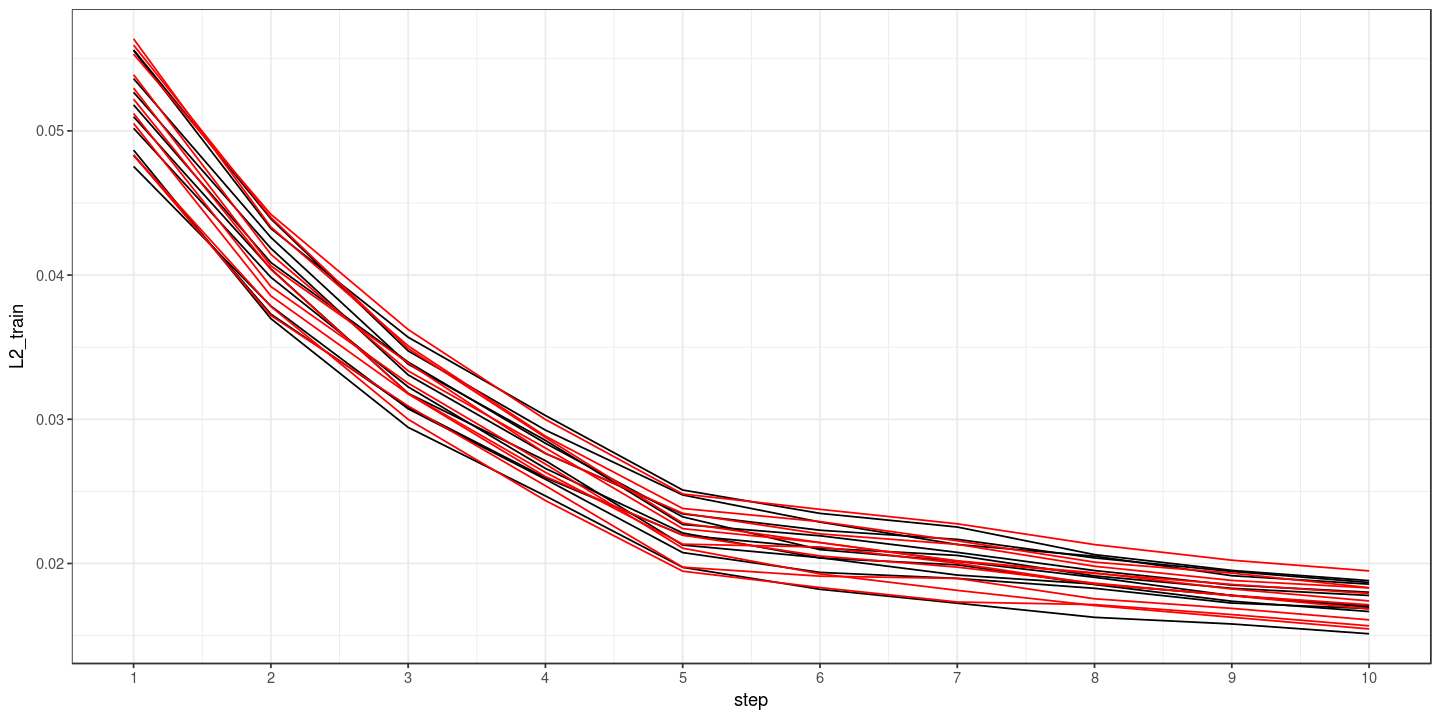

In [54]:
options(repr.plot.width = 12, repr.plot.height = 6)

report %>% 
ggplot() +
geom_line(aes(x=step, y=L2_train, group=sample)) +
geom_line(aes(x=step, y=L2_test, group=sample), color='red') +
scale_x_continuous(breaks=c(1:max(avg_report$step))) +
theme_bw()